In [2]:
import os
import json
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import spacy

import transformer_lens
from probe_model import LinearProbe, Trainer, TrainerConfig

## Setup

In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [4]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


In [5]:
baseline = transformer_lens.HookedTransformer(model.cfg)

In [7]:
_, test_cache = baseline.run_with_cache("hello")
test_cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [8]:
# Load the spaCy model
spacy_model = spacy.load("en_core_web_sm")

## Generate dataset

### Load text

In [9]:
with open('datasets/prewar.txt', 'r') as f:
    raw_sentences = [line.rstrip("\n") for line in f.readlines()]

DATASET_CUTOFF = 10000
raw_sentences = raw_sentences[:DATASET_CUTOFF]
np.random.choice(raw_sentences, 5)

array(['" not being able to approve all of its provisions , i herewith return it to the senate , in which house it originated , with a brief statement of my objections .',
       'the discovery having been made that many names had been put upon the pension roll by means of wholesale and gigantic frauds , the commissioner suspended payments upon a number of pensions which seemed to be fraudulent or unauthorized pending a complete examination , giving notice to the pensioners , in order that they might have an opportunity to establish , if possible , the justice of their claims notwithstanding apparent invalidity .',
       'it may not have been admitted in so many words to the code of international law , but since in international councils every nation is entitled to the rights belonging to it , if the enforcement of the monroe doctrine is something we may justly claim it has its place in the code of international law as certainly and as securely as if it were specifically mentioned ; a

### Generating text sequences with labels (word index)

In [10]:
def map_word_index(text, prepend_bos=False):
    gpt_tokens = model.to_tokens(text, prepend_bos=prepend_bos).squeeze(0)
    gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]

    doc = spacy_model(str(text))
    word_idxs = [t.text for t in doc if t.is_alpha]

    if not len(word_idxs):
        return torch.Tensor(), []

    i = 0
    cur = 0 # current word index
    sub_idx = 0 # sub index of current word

    result = []
    while i < len(gpt_tokens_str):
        t = gpt_tokens_str[i].strip()
        # skip if token is just a newline or other whitespace
        if not len(t):
            result.append((t, i, -1))
            i += 1
            continue

        cur_word = word_idxs[cur]
        # if token is part of current word, update sub_idx, continue to next token
        if cur_word.find(t, sub_idx) != -1:
            result.append((t, i, cur))
            sub_idx += len(t)
            i += 1
        else:
            # if token not in cur_word, check next word
            if cur+1 < len(word_idxs) and t in word_idxs[cur+1]:
                cur += 1
                sub_idx = 0
            # if not in cur_word or next word, give up and continue
            else:
                result.append((t, i, -1))
                i += 1 

    return gpt_tokens, result

In [8]:
# check that map_word_index function is working correctly
# for s in tqdm(raw_sentences):
#     tokens, info = map_word_index(s)
#     assert len(tokens) == len(info)

In [20]:
SEQ_LEN = 500

def generate_seq():
    tokens = model.to_tokens("\n", prepend_bos=True).squeeze(0)
    info = [("\n", 0, -1)]

    while len(tokens) < SEQ_LEN:
        next_t, next_info = map_word_index(np.random.choice(raw_sentences))
        if len(next_t):
            tokens = torch.cat((tokens, next_t))
            info.extend(next_info)

    labels = np.array(list(map(lambda x: x[2], info)))
    return tokens, labels

tokens, labels = generate_seq()
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58]),
 array([50, 17, 18, 16, 21, 19, 16, 18, 16, 18, 14, 15, 17, 15, 14, 14, 16,
        12, 10,  9, 10,  9,  7,  7,  6,  6,  6,  6,  6,  5,  4,  4,  4,  6,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  2,  2,  2,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1]))

### Generate Embeddings

In [24]:
N_SEQS = 100
# cutoff initial tokens because model behavior is weird there
PREFIX_CUTOFF = 10

torch.set_grad_enabled(False)

all_pos_embed = []
all_resids = []
all_labels = []

for i_batch in tqdm(range(N_SEQS)):
    tokens, labels = generate_seq()

    _, cache = baseline.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # residuals.shape = (layer, batch, seq_len, model_residual_dimension)
    residuals = residuals[:, 0, PREFIX_CUTOFF+1:, :]
    labels = labels[PREFIX_CUTOFF:]

    assert residuals.shape[1] == labels.shape[0]

    # this mask excludes puncuation and word fragments
    mask = labels != -1

    all_resids.append(residuals.cpu().numpy()[:, mask])
    all_labels.append(labels[mask])

    _, cache2 = baseline.run_with_cache(tokens, names_filter=lambda x: "pos_embed" in x)
    pos_embed = cache2['hook_pos_embed'][0, PREFIX_CUTOFF+1:, :]

    all_pos_embed.append(pos_embed.cpu().numpy()[mask])


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


In [25]:
x_pos_embed = np.concatenate(all_pos_embed)
x_all_layers = np.concatenate(all_resids, axis=1)
y_all = np.concatenate(all_labels)

print(x_pos_embed.shape)
print(x_all_layers.shape)
print(y_all.shape)

(45789, 768)
(12, 45789, 768)
(45789,)


### filter data

In [28]:
LAYER = 2

# only look at labels for words 0-9
mask = y_all <= 9

# X = x_all_layers[LAYER, mask]
X = x_pos_embed[mask]
Y = y_all[mask]

print(X.shape)
print(Y.shape)

(13242, 768)
(13242,)


## Training Probes

In [29]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"dataset: {len(act)} pairs loaded...")
        self.act = act
        self.y = y
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.act[idx]), torch.tensor(self.y[idx]).long()

In [30]:
probing_dataset = ProbingDataset(X, Y)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
print(f"split into [test/train], [{test_size}/{train_size}]")

dataset: 13242 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1439, 1359, 1323, 1327, 1318, 1308, 1277, 1286, 1294, 1311]))
split into [test/train], [2649/10593]


In [31]:
probe = LinearProbe(device, 768, 10)

EXPERIMENT_NAME = "prewar_baseline"
folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
config = TrainerConfig(num_epochs=40, ckpt_path=folder)
trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

In [32]:
trainer.train()

Epoch 40; Train Loss: inf; Train Acc: 10.441%; Test Acc: 9.551%: 100%|██████████| 40/40 [00:07<00:00,  5.33it/s]


In [33]:
print(trainer.generate_report())

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       322
           1     0.0955    1.0000    0.1744       253
           2     0.0000    0.0000    0.0000       263
           3     0.0000    0.0000    0.0000       237
           4     0.0000    0.0000    0.0000       278
           5     0.0000    0.0000    0.0000       264
           6     0.0000    0.0000    0.0000       250
           7     0.0000    0.0000    0.0000       243
           8     0.0000    0.0000    0.0000       264
           9     0.0000    0.0000    0.0000       275

    accuracy                         0.0955      2649
   macro avg     0.0096    0.1000    0.0174      2649
weighted avg     0.0091    0.0955    0.0167      2649



/home/jnb5885/miniconda3/envs/ling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jnb5885/miniconda3/envs/ling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jnb5885/miniconda3/envs/ling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

### plotting loss curves

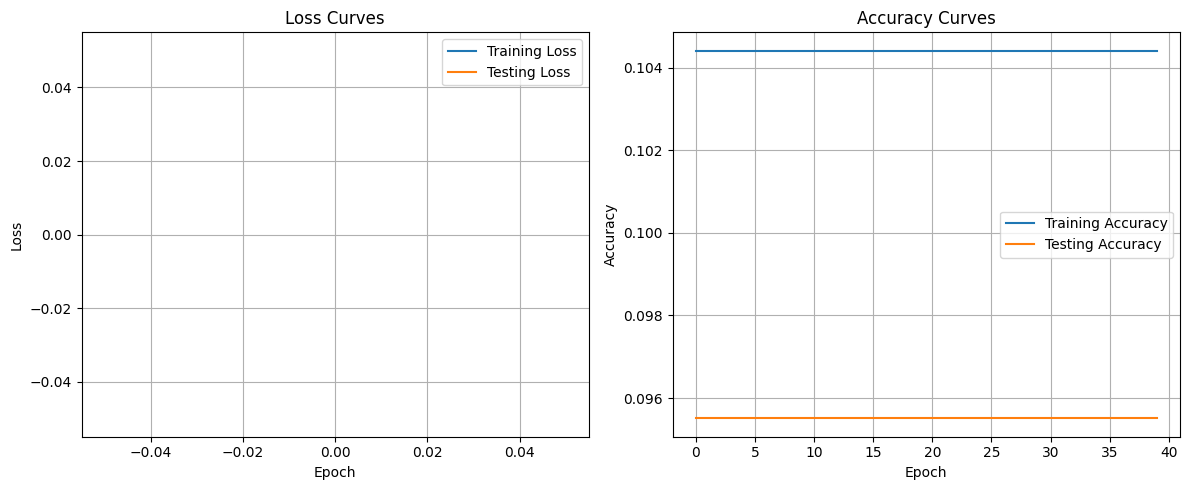

In [34]:
metrics_path = os.path.join(folder, 'metrics.json')

# Load the metrics from the JSON file
with open(metrics_path, 'r') as f:
    metrics = json.load(f)['metrics']

# Extract the loss and accuracy data
train_loss = metrics['train_loss']
test_loss = metrics['test_loss']
train_acc = metrics['train_acc']
test_acc = metrics['test_acc']

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()